#### Import libraries

In [22]:
import pandas as pd
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, learning_curve
import matplotlib.pyplot as plt
import numpy as np

#### Load processed dataset and prepare our training and test set

In [23]:
training_set_path = "../data/processed/training_boston.csv"
test_set_path = "../data/processed/test_boston.csv"

training_set = pd.read_csv(training_set_path)
test_set = pd.read_csv(test_set_path)

X_train = training_set.drop(columns = ["MEDV"])
X_test = test_set.drop(columns = ["MEDV"])
y_train = training_set["MEDV"]
y_test = test_set["MEDV"]

#### Define our gradient boosting model (XGBoost)

In [24]:
model = XGBRegressor(random_state = 492)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

#### Evaluate performance metrics of our model
* Loss value and R2 (correlation coefficient) value is computed based on the default values of hyperparameters. We'll use an hyperparameter optimization technique such as Grid Search to improve the accuracy and generalizability of our model.

In [25]:
# rmse value as loss
loss = root_mean_squared_error(y_test, y_pred)
r2_val = r2_score(y_test, y_pred)

print(f"Model RMSE: {loss}")
print(f"Model R²: {r2_val}")

Model RMSE: 3.593491843441745
Model R²: 0.8419638129500432


#### Hyperparameter optimization
* Implemented a grid search and obtained better (as the result of performance metrics suggest) hyperparameters for our model

<Figure size 1000x800 with 0 Axes>

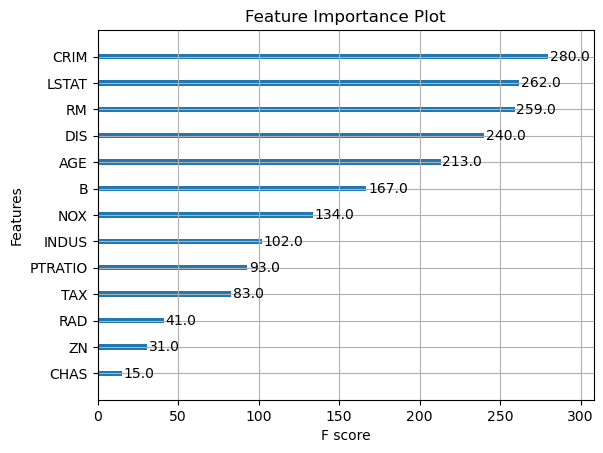

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.6}


In [26]:
"""
n_estimators - # of trees (m in the equation)
learning_rate - gamma in the equation (step size shrinkage)
max_depth - max depth of each tree that will be created during boosting process
min_child_weight - prevent overfitting (define a threshold for node splitting based on sum of child weights)
subsample - ratio of data points going to be used while creating each tree (1.0 -> whole training data)
colsample_bytree - fraction of features going to be used while creating each tree (introduce randomness and prevent ofitting)
"""

# param_grid -> defined dictionary that is going to be used for grid search (hyperparam optim)
param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 4, 5],
    "min_child_weight": [1, 3, 5],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

# n_jobs param -> # of processors going to be used (-1 : all)
# cv -> cross validation strategy (5 : default)
# scoring -> strategy to evaluate performance of CV (takes a scoring parameter)
grid_search = GridSearchCV(estimator=XGBRegressor(random_state=42), 
                           param_grid=param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search.fit(X_train, y_train)
params = grid_search.best_params_
best_model = grid_search.best_estimator_

plt.figure(figsize = (10,8))
plot_importance(best_model)
plt.title("Feature Importance Plot")
plt.show()

print(f"Best Parameters: {params}")

#### Plot the learning curve

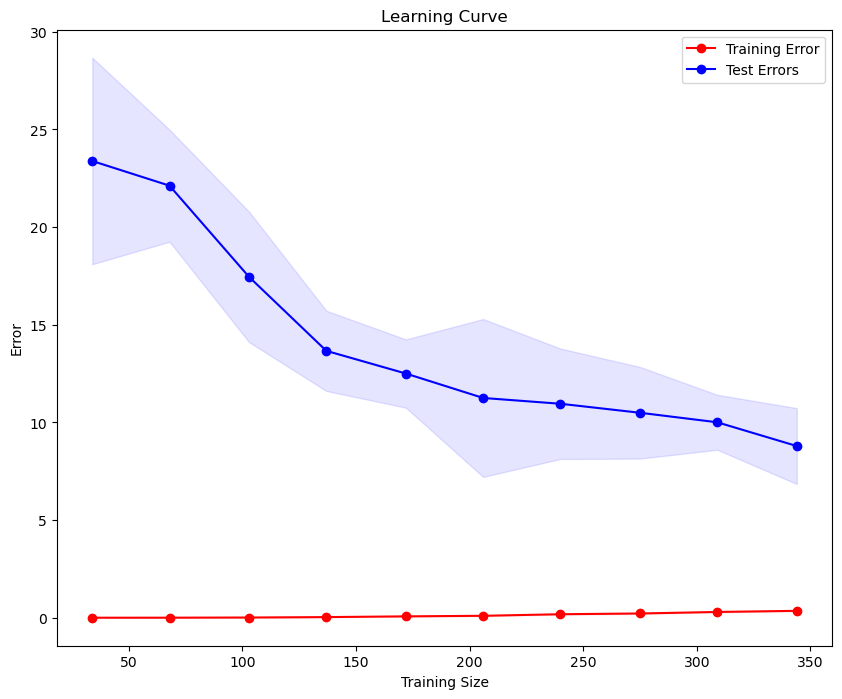

In [27]:
X = np.vstack((X_train, X_test))
y = np.concatenate((y_train, y_test))
train_sizes, train_losses, test_losses = learning_curve(
    best_model, X, y, cv=5, scoring="neg_mean_squared_error", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)) # 10-20-30...


# mean and std calculations for learning curve plotting
# * -1 from neg_mean_squared_error
train_scores_mean = -train_losses.mean(axis=1)
test_scores_mean = -test_losses.mean(axis=1)
train_scores_std = train_losses.std(axis=1)
test_scores_std = test_losses.std(axis=1)

plt.figure(figsize=(10,8))
plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training Error")
plt.plot(train_sizes, test_scores_mean, "o-", color="b", label="Test Errors")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="b")
plt.xlabel("Training Size")
plt.ylabel("Error")
plt.title("Learning Curve")
plt.legend(loc = "best")    # loc -> location param, "best" for auto-choice that does not overlap with datapoints
plt.show()

#### Evaluate performance metrics of the optimized model

In [28]:
y_pred_best = best_model.predict(X_test)

best_model_loss = root_mean_squared_error(y_test, y_pred_best)
best_model_r2 = r2_score(y_test, y_pred_best)

print(f"Best model RMSE: {best_model_loss}")
print(f"Best model R²: {best_model_r2}")

Best model RMSE: 3.284643243644806
Best model R²: 0.8679617898735554
